In [1]:
# %%bash
# pip install scikeras

In [2]:
import pandas as pd
import numpy as np
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score, accuracy_score, precision_score, recall_score, precision_recall_curve, fbeta_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.utils import class_weight
from _functions import (
    custom_classification_report,
    get_max_fscore_i, 
    plot_PR_curve,
    plot_PR_threshold_curve,
    plot_confusion_matrix, 
    plot_loss, 
    plot_learning_rate
)

In [3]:
tf.random.set_seed(42)

plt.ioff()

In [ ]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def _ensure_bool_force_flag(estimator):
    if isinstance(estimator, ColumnTransformer):
        if getattr(estimator, "force_int_remainder_cols", None) == "deprecated":
            estimator.set_params(force_int_remainder_cols=False)
    elif isinstance(estimator, Pipeline):
        for step in estimator.steps:
            _ensure_bool_force_flag(step[1])

for name, estimator in models_dict.items():
    _ensure_bool_force_flag(estimator)
    models_dict[name] = estimator

In [5]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
                  'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
                  'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
X_cat_cols = ['country_state']
y_col = ['fraudulent']

# df2 = df[X_numeric_cols + X_text_cols + X_cat_cols + y_col].dropna()
df2 = df.loc[:300, X_numeric_cols + X_text_cols + X_cat_cols + y_col].dropna()

X = df2[X_numeric_cols+X_text_cols+X_cat_cols]
y = df2[y_col].values.ravel()  # Convert to 1D array

In [6]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to TF-IDF features so that the neural network can process them
preprocessor = ColumnTransformer(
    transformers=[
        ("title_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "title"),
        ("dnr_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "description_and_requirements"),
        ("num_scaled", MinMaxScaler(), X_numeric_cols),
        ("cat_encoded", OneHotEncoder(handle_unknown='ignore', sparse_output=True), X_cat_cols)
    ],
    remainder='drop'
)

# Combine numeric and text features
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Training shape: {X_train_processed.shape}")
print(f"Test shape: {X_test_processed.shape}")

Training shape: (238, 5410)
Test shape: (60, 5410)


In [7]:
# def build_model(meta):
    # params = meta["params"]
    # layer_sizes = params["model__layer_sizes"]
    # learning_rate = params["model__learning_rate"]
    # input_dim = params["model__input_dim_"]
# def build_model(layer_sizes, learning_rate, input_dim):

#     model = models.Sequential()
#     model.add(layers.Input(shape=(input_dim,)))
    
#     for size in layer_sizes:
#         model.add(layers.Dense(size, activation='relu'))
    
#     model.add(layers.Dense(1, activation='sigmoid'))  # outputs log-likelihood
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

def build_model(layer_sizes, learning_rate, input_dim):
    model = models.Sequential([layers.Input(shape=(input_dim,))])
    for size in layer_sizes:
        model.add(layers.Dense(size, activation="relu"))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
class_weights

{0: np.float64(0.5063829787234042), 1: np.float64(39.666666666666664)}

In [8]:

# different architectures to compare
architectures = {
    "Shallow": [32],
    "Medium": [64, 32],
    "Deep": [128, 64, 32],
    "Deeper": [128, 64, 32, 16],
    "Wide": [256, 128],
    "Wider": [512, 128],
    "Deeper and Wider":[512, 256, 128, 32]
}

learning_rates = [
    # 0.003,
    0.001,
    # 0.0003
]

# dictionary to store evaluation results, histories, trained models, and plots
results = {}
histories = {}
trained_models = {}
plots = {}

In [9]:
X_train_processed = X_train_processed.astype(np.float32)
X_test_processed = X_test_processed.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [10]:
k = 5
kF = KFold(n_splits=k, shuffle=True, random_state=42)
list(kF.split(X_train_processed))[3]

(array([  0,   1,   2,   4,   5,   6,   9,  10,  11,  12,  14,  15,  16,
         18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,  30,  31,
         32,  33,  35,  36,  37,  38,  41,  42,  44,  45,  46,  48,  50,
         51,  52,  54,  55,  56,  57,  58,  60,  61,  62,  64,  65,  66,
         67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,  79,  82,
         84,  85,  86,  87,  88,  90,  92,  93,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128,
        129, 130, 132, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159,
        160, 162, 164, 165, 167, 168, 169, 170, 173, 174, 175, 177, 178,
        179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
        194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 207, 209,
        210, 212, 213, 214, 217, 219, 221, 222, 223


Training Shallow...

Training Shallow (Fold 1)...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Training Shallow (Fold 2)...


c:\Users\Jason\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jason\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jason\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Training Shallow (Fold 3)...
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001DE90E78680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Training Shallow (Fold 4)...


c:\Users\Jason\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Training Shallow (Fold 5)...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\Jason\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jason\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jason\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

ValueError: Classification metrics can't handle a mix of binary and continuous targets

<Figure size 600x400 with 0 Axes>

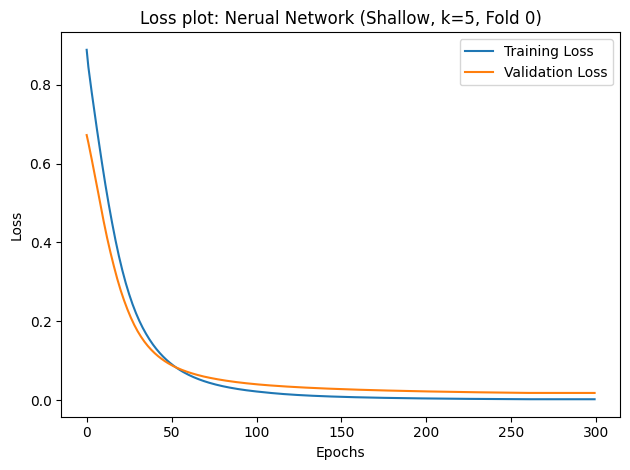

<Figure size 600x400 with 0 Axes>

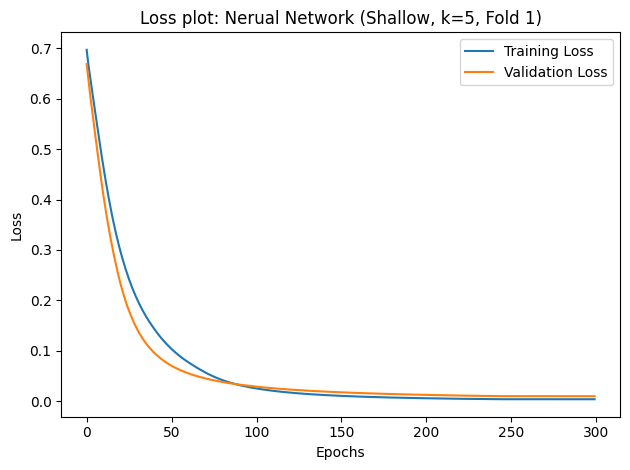

<Figure size 600x400 with 0 Axes>

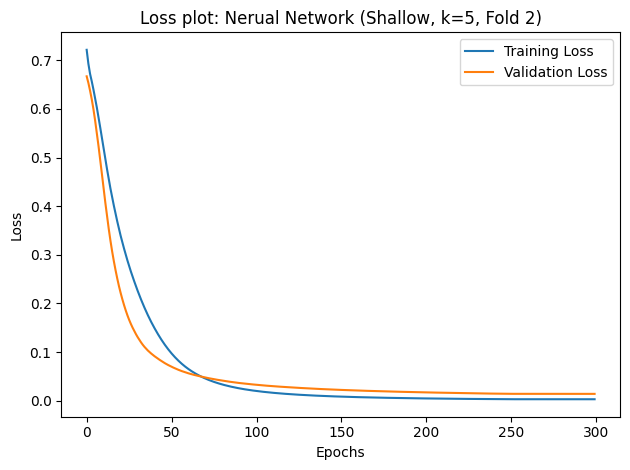

<Figure size 600x400 with 0 Axes>

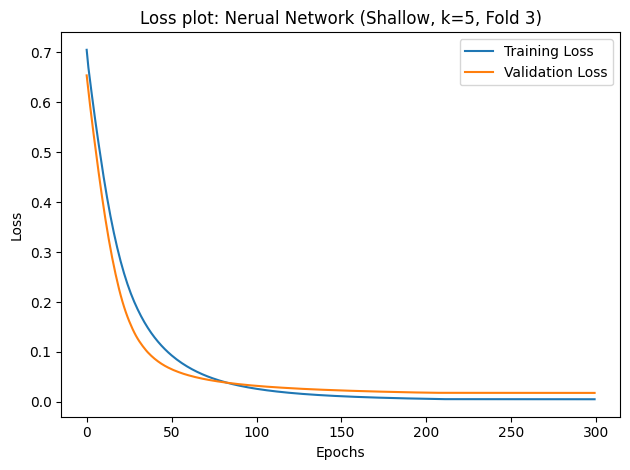

<Figure size 600x400 with 0 Axes>

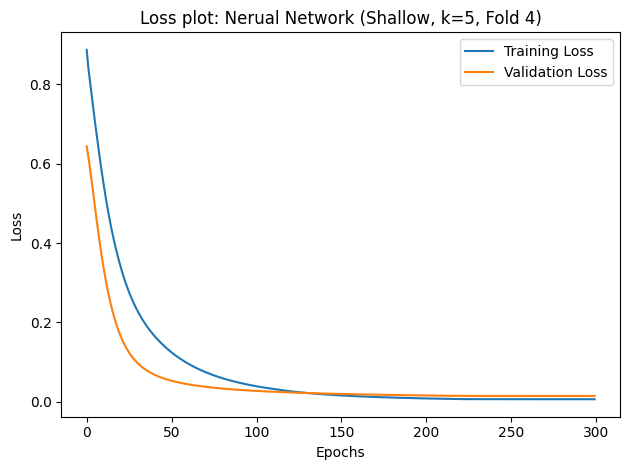

<Figure size 600x400 with 0 Axes>

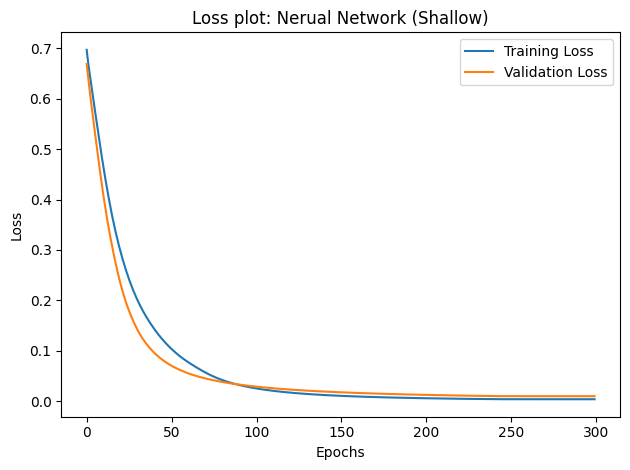

In [11]:
# Train and evaluate each model architecture

k = 5
kF = KFold(n_splits=k, shuffle=True, random_state=42)

for (layer_name, layer_sizes), learning_rate in product(architectures.items(), learning_rates):
    name = layer_name
    print(f"\nTraining {name}...")
    
    results_folds = []
    histories_folds = []
    trained_models_folds = []
    plots_folds = []

    for fold, (train_i, val_i) in enumerate(kF.split(X_train_processed)):
        print(f"\nTraining {name} (Fold {fold+1})...")
        
        X_train_processed_fold, X_val_processed_fold = X_train_processed[train_i], X_train_processed[val_i]
        y_train_fold, y_val_fold = y_train[train_i], y_train[val_i]
        
        model = build_model(layer_sizes, learning_rate, X_train_processed_fold.shape[1])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # patience is the number of epochs to tolerate
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=2, min_lr=0.00003)
        model_history = model.fit(X_train_processed_fold, y_train_fold, validation_split=0.2, 
                            epochs=300, batch_size=128,                 # we need a big batch size as our dataset is imbalanced with minority class of 5%
                            class_weight=class_weights,                 # class_weights also address for the imbalance
                            callbacks=[early_stopping, reduce_lr],      # reduce_lr reduces the learning rate when the val_loss does not change signifiantly
                            verbose=0) 
        
        # Make predictions
        y_pred_proba = model.predict(X_val_processed_fold).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate classification metrics
        f2 = fbeta_score(y_val_fold, y_pred, beta=2)
        accuracy = accuracy_score(y_val_fold, y_pred)
        precision = precision_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)
        
        results_folds.append({"F2": f2, "Accuracy": accuracy, "Precision": precision, "Recall": recall})      # store the result
        trained_models_folds.append(model)                                                                    # store the trained model
        histories_folds.append(model_history.history)                                                      # store the history
        plots_folds.append(plot_loss(model_history.history, f"Loss plot: Nerual Network ({name}, k={k}, Fold {fold})", dont_show=True))

    best_i = np.argmax([results_folds[i]["F2"] for i in range(k)])
    
    # store results
    results[name] = {
        "F2": results_folds[best_i]["F2"], 
        "Accuracy": results_folds[best_i]["Accuracy"], 
        "Precision": results_folds[best_i]["Precision"], 
        "Recall": results_folds[best_i]["Recall"]
    }      # store the result
    trained_models[name] = trained_models_folds[best_i]                                                                    # store the trained model
    histories[name] = histories_folds[best_i]                                                # store the history
    plots[name] = plot_loss(histories[name], f"Loss plot: Nerual Network ({name})", dont_show=True)

    val_i = list(kF.split(X_train_processed))[best_i][1]
    X_val_processed_fold_best, y_val_fold_best = X_train_processed[val_i], y_train[val_i]
    print(custom_classification_report(y_val_fold_best, trained_models_folds[best_i].predict(X_val_processed_fold_best).reshape(-1), target_names=['Not Fraud', 'Fraud']))


In [ ]:
y_val_fold_best.shape, trained_models_folds[best_i].predict(X_val_processed_fold_best).reshape(-1).shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


((48,), (48,))

In [ ]:
y_val_fold_best

(array([    0,     1,     2, ..., 14420, 14421, 14423], shape=(11540,)),
 array([    8,    14,    15, ..., 14422, 14424, 14425], shape=(2886,)))

In [ ]:
# Display results for each model
for name, metrics in results.items():
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    print(custom_classification_report(y_test.astype(int), y_pred, target_names=['Not Fraud', 'Fraud']))

# Find best model by F2 score
best_model_name = max(results, key=lambda x: results[x]['F2'])
best_model = trained_models[best_model_name] 

# Predictions and confusion matrix
y_pred_proba = best_model.predict(X_test_processed).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"\nClassification Report ({best_model_name}):")
print(custom_classification_report(y_test.astype(int), y_pred, target_names=['Not Fraud', 'Fraud']))

plot_confusion_matrix(confusion_matrix(y_test.astype(int), y_pred, labels=[0, 1]), 
                      f"Confusion Matrix: Nerual Network ({best_model_name})")
plot_loss(histories[best_model_name], f"Loss plot: Nerual Network ({best_model_name})")
plot_learning_rate(histories[best_model_name]['learning_rate'], f"Loss plot: Nerual Network ({best_model_name})")

ValueError: max() iterable argument is empty

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
           precision    recall  f1-score  f2-score   support

Not Fraud      0.992     0.990     0.991     0.990      3361
    Fraud      0.869     0.886     0.877     0.883       246

 accuracy                                    0.983      3607



<Figure size 600x400 with 0 Axes>

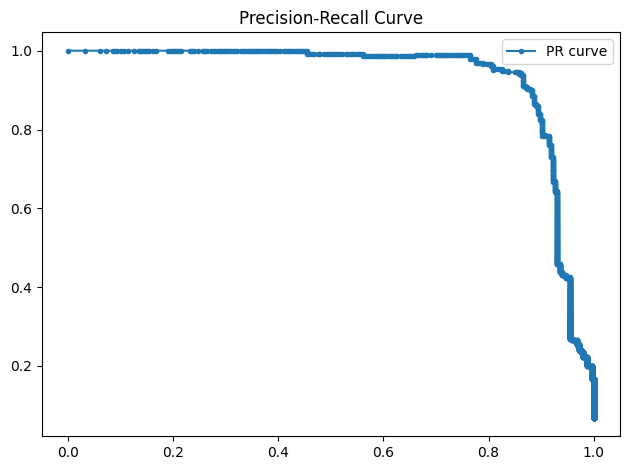

<Figure size 600x400 with 0 Axes>

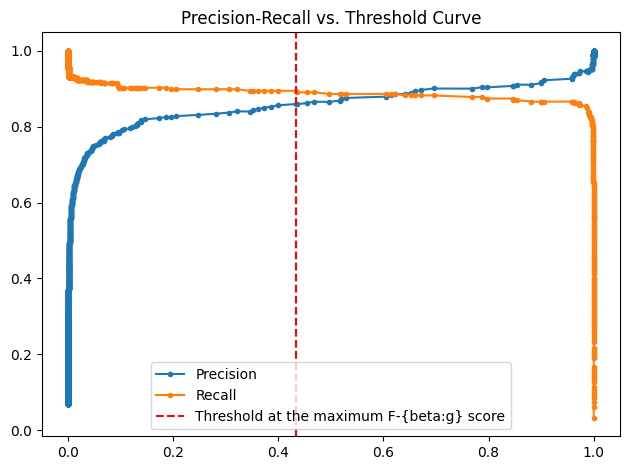

<Figure size 600x500 with 0 Axes>

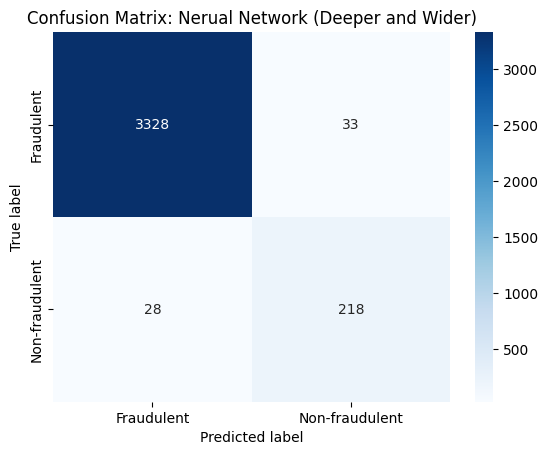

In [ ]:
# model = trained_models['Shallow with LR of 0.001']
model = best_model
y_pred_proba = model.predict(X_test_processed).flatten()

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

print(custom_classification_report(y_test, (y_pred_proba > 0.5), beta=2, digits=3))

fig, ax = plot_PR_curve(precision, recall)
fig, ax = plot_PR_threshold_curve(precision, recall, thresholds)
fig, ax = plot_confusion_matrix(
    confusion_matrix(y_test.astype(int), y_pred, labels=[0, 1]), 
    f"Confusion Matrix: Nerual Network ({best_model_name})"
)

In [ ]:
max_f1_i = get_max_fscore_i(precision, recall, beta=1.0)

print('F1 score report: Using threshold of 0.5')
print(custom_classification_report(y_test, (y_pred_proba >= 0.5).astype(int), beta=1, digits=3))

print(f'F1 score report: Using threshold of {thresholds[max_f1_i]:.2f}') 
print(custom_classification_report(y_test, (y_pred_proba >= thresholds[max_f1_i]).astype(int), beta=1, digits=3))

max_f2_i = get_max_fscore_i(precision, recall, beta=2.0)
print()
print('F2 score report: Using threshold of 0.5')
print(custom_classification_report(y_test, (y_pred_proba >= 0.5).astype(int), beta=2, digits=3))

print(f'F2 score report: Using threshold of {thresholds[max_f2_i]:.2f}') 
print(custom_classification_report(y_test, (y_pred_proba >= thresholds[max_f2_i]).astype(int), beta=2.0, digits=3))

F1 score report: Using threshold of 0.5
           precision    recall  f1-score  f1-score   support

Not Fraud      0.992     0.990     0.991     0.991      3361
    Fraud      0.869     0.886     0.877     0.877       246

 accuracy                                    0.983      3607

F1 score report: Using threshold of 0.96
           precision    recall  f1-score  f1-score   support

Not Fraud      0.990     0.996     0.993     0.993      3361
    Fraud      0.938     0.866     0.901     0.901       246

 accuracy                                    0.987      3607


F2 score report: Using threshold of 0.5
           precision    recall  f1-score  f2-score   support

Not Fraud      0.992     0.990     0.991     0.990      3361
    Fraud      0.869     0.886     0.877     0.883       246

 accuracy                                    0.983      3607

F2 score report: Using threshold of 0.43
           precision    recall  f1-score  f2-score   support

Not Fraud      0.992     0.989    